In [67]:
#--- import required modules for assignment ---
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report,confusion_matrix, roc_auc_score, roc_curve

%matplotlib inline

In [68]:
#--- set default seaborn plot properties ---
sns.set(style='whitegrid')

In [69]:
#--- define column names based on the attribute information ---
column_names = [
    'age', 'workclass', 'final-weight', 'education', 'education-num',
    'marital-status', 'occupation', 'relationship', 'race', 'sex',
    'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income'
]

#--- load training data ---
train_data_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data'

train_df = pd.read_csv(train_data_url, header=None, names=column_names, na_values=' ?')

In [70]:
#--- group columns into object ad numeric dtypes ---
categorical_columns = train_df.select_dtypes(include='object').columns
numerical_columns = train_df.select_dtypes(include=['int64','float64']).columns

In [71]:
#--- define a function to remove space and display unique values and counts ---
def obj_val_count(df):
  for col in df[categorical_columns]:

    #--- remove space from values ---
    df[col] = df[col].str.strip()

    #--- print out unique values and counts ---
    print(f'The unique values in {col} are: \n {df[col].value_counts()}')
    print('\t\t\t\t')

In [72]:
#--- call function to display result for train dataframe---
obj_val_count(train_df)

The unique values in workclass are: 
 workclass
Private             22696
Self-emp-not-inc     2541
Local-gov            2093
State-gov            1298
Self-emp-inc         1116
Federal-gov           960
Without-pay            14
Never-worked            7
Name: count, dtype: int64
				
The unique values in education are: 
 education
HS-grad         10501
Some-college     7291
Bachelors        5355
Masters          1723
Assoc-voc        1382
11th             1175
Assoc-acdm       1067
10th              933
7th-8th           646
Prof-school       576
9th               514
12th              433
Doctorate         413
5th-6th           333
1st-4th           168
Preschool          51
Name: count, dtype: int64
				
The unique values in marital-status are: 
 marital-status
Married-civ-spouse       14976
Never-married            10683
Divorced                  4443
Separated                 1025
Widowed                    993
Married-spouse-absent      418
Married-AF-spouse           23
Name: c

From the above information displayed, we can see that the dataset contains missing values. I will now drop the missing data and reset index

In [73]:
''' define a function to display dataframe descriptive statistics, info, count number of null values in dataframe, then drop the null values and reset index '''

def df_overview(df,df_name):
  #--- display dataframe descriptive statistics ---
  print(f'Descriptive statistics of the {df_name} is \n {df.describe()[1:].T}')
  print('\n')

  #--- display dataframe info ---
  print(f'{df_name} information \n {df.info()}')
  print('\n')

  #--- print count before removing null values ---
  print(f'This dataframe contain the following missing values before cleaning \n {df.isnull().sum()}')
  print('\n')

  #--- drop null values and reset dataframe index ---
  df = df.dropna(how='any').reset_index(drop=True)

  #--- print count after removing null values ---
  print(f'This dataframe contain the following missing values after cleaning \n {df.isnull().sum()}')

  return df

In [74]:
# Display info for train dataframe, drop null values and re-assign dataframe
train_df = df_overview(train_df, 'train dataset')

Descriptive statistics of the train dataset is 
                          mean            std      min       25%       50%  \
age                 38.581647      13.640433     17.0      28.0      37.0   
final-weight    189778.366512  105549.977697  12285.0  117827.0  178356.0   
education-num       10.080679       2.572720      1.0       9.0      10.0   
capital-gain      1077.648844    7385.292085      0.0       0.0       0.0   
capital-loss        87.303830     402.960219      0.0       0.0       0.0   
hours-per-week      40.437456      12.347429      1.0      40.0      40.0   

                     75%        max  
age                 48.0       90.0  
final-weight    237051.0  1484705.0  
education-num       12.0       16.0  
capital-gain         0.0    99999.0  
capital-loss         0.0     4356.0  
hours-per-week      45.0       99.0  


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Coun

In [75]:
'''
  Set target column in train and test dataframe to numeric, where 0 represent <=50K and 1 represent >50K
'''

train_df['income'] = np.where(train_df['income'] == '<=50K', 0 , 1)

In [76]:
#--- show distribution of value of the income column ---

def plot_count(df, df_name):
  fig, ax = plt.subplots(figsize=(12, 8))

  #--- plot for the dataframe ---
  sns.countplot(data=df, x='income', palette='coolwarm', legend='auto')

  #--- add data label to the bars ---
  for count in ax.containers:
    ax.bar_label(count, weight='medium', fontsize=12, padding=3)

  #--- set plot properties ---
  ax.set_title(f'Income Distribution for {df_name}', weight='bold', pad=10)
  ax.set_ylabel('Frequency')
  plt.tight_layout()
  plt.grid(False)
  plt.show()

  return

<ipython-input-76-cf6cd0a7882f>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='income', palette='coolwarm', legend='auto')


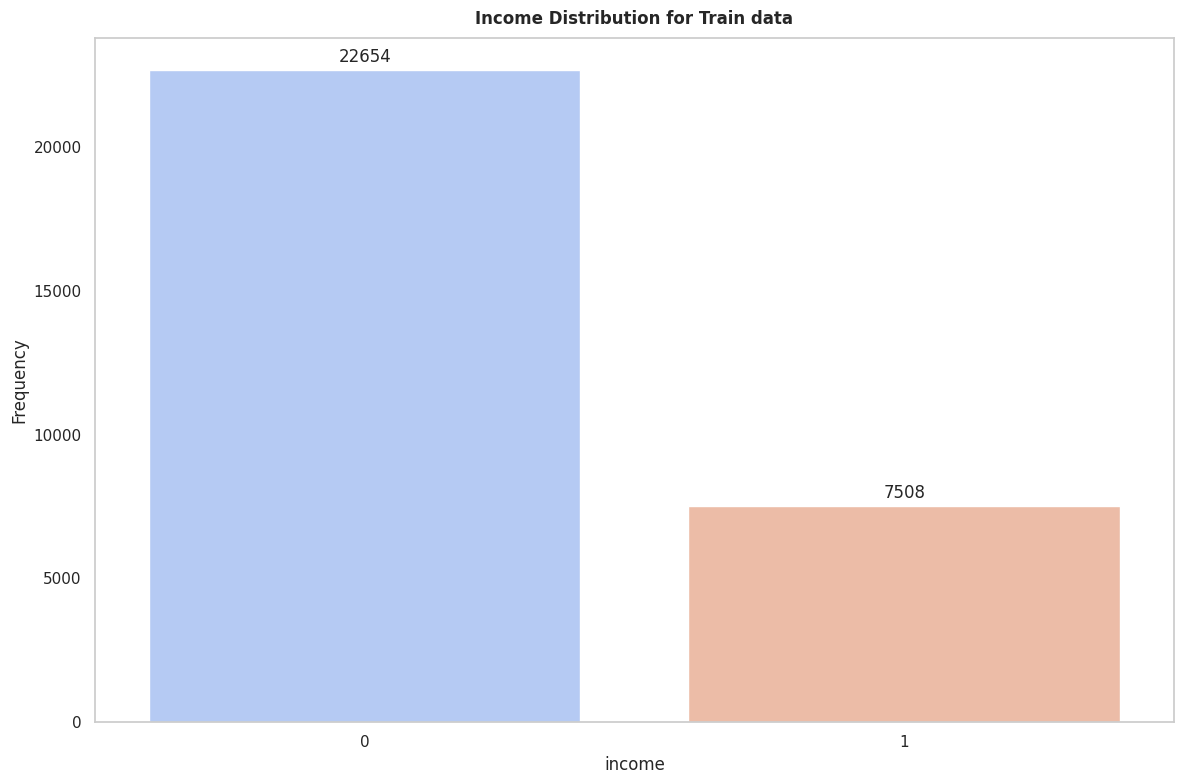

In [77]:
#--- show income distribution for train dataset ---
plot_count(train_df,'Train data')

From the above plots, we can see we have more 0 (<=50K) than 1 (>50K). That implies an imbalace class.


---



In [78]:
#--- function to check duplicates and drop if any found ---
def df_dup_drop(df, df_name):

  #--- check for duplicate values ---
  num_of_duplicates = df.duplicated().sum()
  print(f'There are {num_of_duplicates} duplicates in the {df_name}')

  #--- drop duplicates ---
  df = df.drop_duplicates(keep='first', ignore_index=True)

  #--- print duplicates dropped ---
  print(f'Duplicates dropped in the {df_name} \n')

  return df

In [79]:
# Display info for train dataframe, drop null values and re-assign dataframe
train_df = df_dup_drop(train_df, 'train dataset')

There are 23 duplicates in the train dataset
Duplicates dropped in the train dataset 



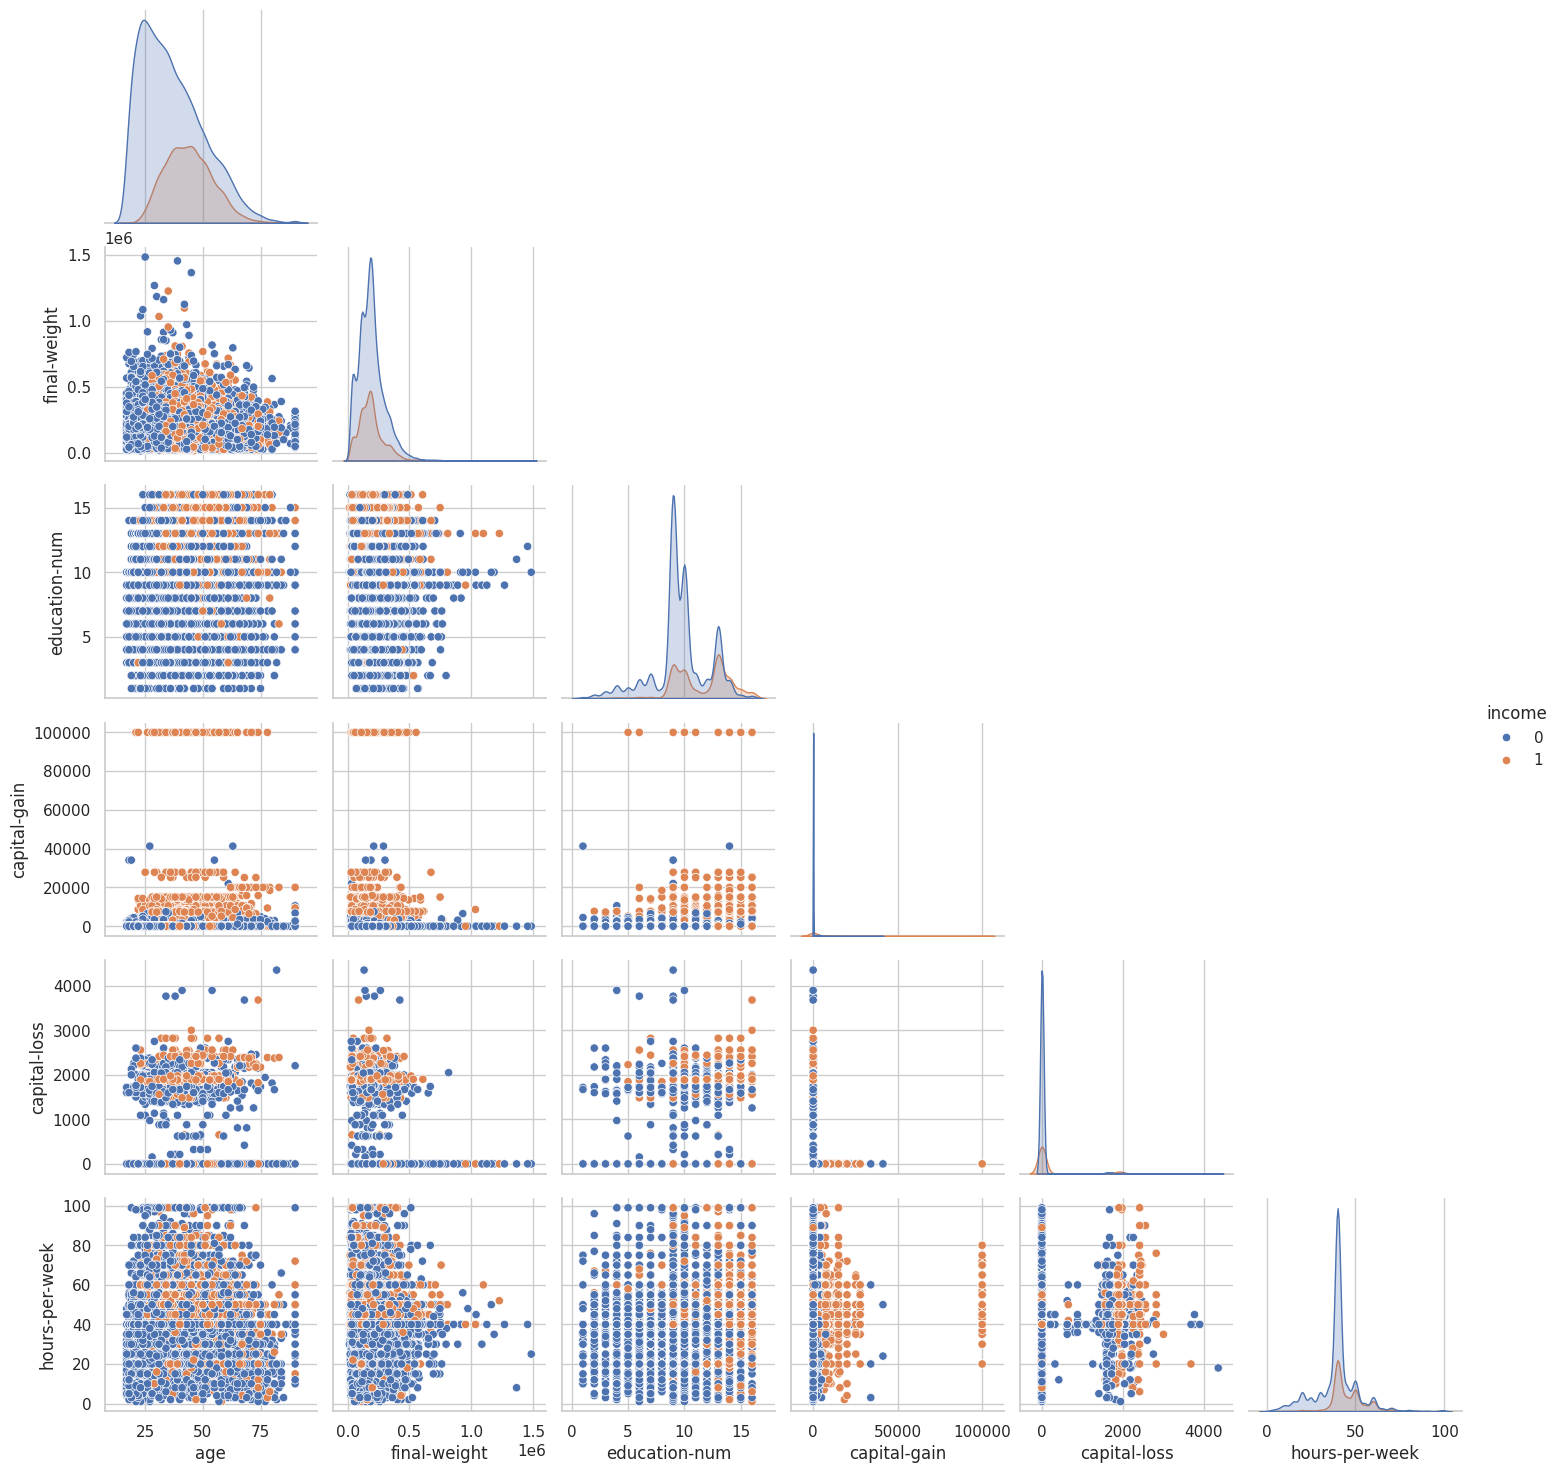

In [80]:
#--- display pairplot ---
sns.pairplot(data=train_df, hue='income', corner=True)

In [81]:
'''
  drop target columns from each dataframe and hold target column in a seperate column for later use
'''
#--- drop target columns from train dataframe and hold in seperate variables ---
train_features = train_df.drop('income', axis=1)
train_target = train_df['income']

In [82]:
#--- seperate categorical and numerical data type for us in pipeline implementation ---
cat_train_features = train_features.select_dtypes(include='object').columns
num_train_features = train_features.select_dtypes(include=['int64','float64']).columns

In [83]:
#--- split data for machine learning ---
X_train, X_test, y_train, y_test = train_test_split(train_features, train_target, test_size=0.2, random_state=42)

In [84]:
#--- check the shape of the data splits ---
print(f'X_train has {X_train.shape[0]} rows and {X_train.shape[1]} columns\n')
print(f'X_test has {X_test.shape[0]} rows and {X_test.shape[1]} columns\n')
print(f'y_train has {y_train.shape[0]} rows\n')
print(f'y_test has {y_test.shape[0]} rows\n')

X_train has 24111 rows and 14 columns

X_test has 6028 rows and 14 columns

y_train has 24111 rows

y_test has 6028 rows



In [85]:
#--- preprocess data for machine learning ---
preprocessor = ColumnTransformer([
    ('scaler',StandardScaler(),num_train_features),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False),cat_train_features)
], remainder='passthrough')

# Support vector machine model
In this section, I will focus on bulding a model that focuses on the support vector machine (svm) and the default arguments. I will then check the performance of the model and also make predictions using the model.

In [86]:
#--- make pipeline for svm model ---
svm_pipeline = Pipeline([
    ('preprocessor',preprocessor),
    ('smote',SMOTE(random_state=42)),
    ('model',SVC(kernel='rbf', C=5, probability=True))
])

In [87]:
#--- fit train data into pipeline for model learning ---
svm_pipeline.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scaler', StandardScaler(),
                                                  Index(['age', 'final-weight', 'education-num', 'capital-gain', 'capital-loss',
       'hours-per-week'],
      dtype='object')),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  Index(['workclass', 'education', 'marital-status', 'occupation',
       'relationship', 'race', 'sex', 'native-country'],
      dtype='object'))])),
                ('smote', SMOTE(random_state=42)),
                ('model', SVC(C=5, probability=True))])

In [88]:
#--- make prediction on the test data using the model ---
svm_pred = svm_pipeline.predict(X_test)

In [89]:
#--- check accuracy score of the model ---
svm_test_accuracy = accuracy_score(y_test,svm_pred)
print(f'accuracy score on test data is {(svm_test_accuracy*100):.2f}% ({svm_test_accuracy})')

accuracy score on test data is 82.32% (0.8231585932315859)


In [90]:
#--- check for the classification report of the model ---
svm_class_report = classification_report(y_test,svm_pred)
print(f'{svm_class_report}')

              precision    recall  f1-score   support

           0       0.93      0.82      0.87      4485
           1       0.61      0.83      0.71      1543

    accuracy                           0.82      6028
   macro avg       0.77      0.83      0.79      6028
weighted avg       0.85      0.82      0.83      6028



In [91]:
#--- check for the confusion matrix of the model ---
svm_matrix = confusion_matrix(y_test,svm_pred)
print(f'{svm_matrix}')

[[3675  810]
 [ 256 1287]]


# Decision Tree Classifier model
In this section, I will focus on bulding a model that focuses on the Decision Tree Classifier and the default arguments. I will then check the performance of the model and also make predictions using the model.

In [92]:
#--- make pipeline for svm model ---
dtc_pipeline = Pipeline([
    ('preprocessor',preprocessor),
    ('smote',SMOTE(random_state=42)),
    ('model',DecisionTreeClassifier())
])

In [93]:
#--- fit train data into pipeline for model learning ---
dtc_pipeline.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scaler', StandardScaler(),
                                                  Index(['age', 'final-weight', 'education-num', 'capital-gain', 'capital-loss',
       'hours-per-week'],
      dtype='object')),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  Index(['workclass', 'education', 'marital-status', 'occupation',
       'relationship', 'race', 'sex', 'native-country'],
      dtype='object'))])),
                ('smote', SMOTE(random_state=42)),
                ('model', DecisionTreeClassifier())])

In [94]:
#--- make prediction on the test data using the model ---
dtc_pred = dtc_pipeline.predict(X_test)

In [95]:
#--- check accuracy score of the model ---
dtc_test_accuracy = accuracy_score(y_test,dtc_pred)
print(f'accuracy score on test data is {(dtc_test_accuracy*100):.2f}% ({dtc_test_accuracy})')

accuracy score on test data is 80.51% (0.8050763105507631)


In [96]:
#--- check for the classification report of the model ---
dtc_class_report = classification_report(y_test,dtc_pred)
print(f'{dtc_class_report}')

              precision    recall  f1-score   support

           0       0.88      0.85      0.87      4485
           1       0.61      0.66      0.64      1543

    accuracy                           0.81      6028
   macro avg       0.75      0.76      0.75      6028
weighted avg       0.81      0.81      0.81      6028



In [97]:
#--- check for the confusion matrix of the model ---
dtc_matrix = confusion_matrix(y_test,dtc_pred)
print(f'{dtc_matrix}')

[[3829  656]
 [ 519 1024]]


# Random Forest model
In this section, I will focus on bulding a model that focuses on the Random Forest Algorithm and the default arguments. I will then check the performance of the model and also make predictions using the model.

In [98]:
#--- make pipeline for svm model ---
rf_pipeline = Pipeline([
    ('preprocessor',preprocessor),
    ('smote',SMOTE(random_state=42)),
    ('model',RandomForestClassifier())
])

In [99]:
#--- fit train data into pipeline for model learning ---
rf_pipeline.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scaler', StandardScaler(),
                                                  Index(['age', 'final-weight', 'education-num', 'capital-gain', 'capital-loss',
       'hours-per-week'],
      dtype='object')),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  Index(['workclass', 'education', 'marital-status', 'occupation',
       'relationship', 'race', 'sex', 'native-country'],
      dtype='object'))])),
                ('smote', SMOTE(random_state=42)),
                ('model', RandomForestClassifier())])

In [100]:
#--- make prediction on the test data using the model ---
rf_pred = rf_pipeline.predict(X_test)

In [101]:
#--- check accuracy score of the model ---
rf_test_accuracy = accuracy_score(y_test,rf_pred)
print(f'accuracy score on test data is {(rf_test_accuracy*100):.2f}% ({rf_test_accuracy})')

accuracy score on test data is 84.47% (0.8447246184472462)


In [102]:
#--- check for the classification report of the model ---
rf_class_report = classification_report(y_test,rf_pred)
print(f'{rf_class_report}')

              precision    recall  f1-score   support

           0       0.90      0.89      0.90      4485
           1       0.69      0.71      0.70      1543

    accuracy                           0.84      6028
   macro avg       0.80      0.80      0.80      6028
weighted avg       0.85      0.84      0.85      6028



In [103]:
#--- check for the confusion matrix of the model ---
rf_matrix = confusion_matrix(y_test,rf_pred)
print(f'{rf_matrix}')

[[4004  481]
 [ 455 1088]]


# Roc curve visualization for models

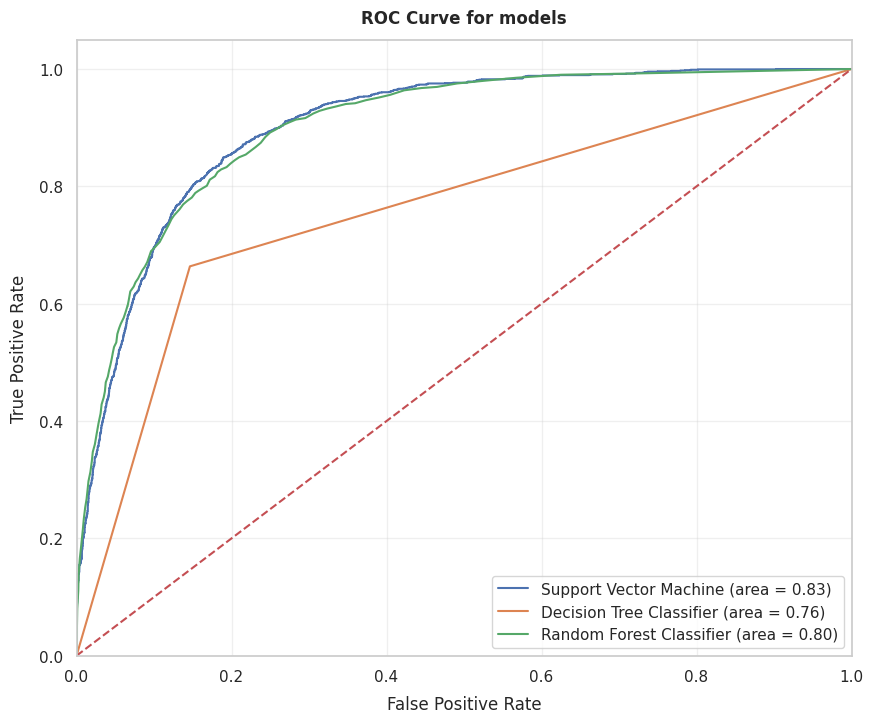

In [104]:
#--- get useful parameters for the models ---
svm_roc_auc = roc_auc_score(y_test, svm_pipeline.predict(X_test))
svm_fpr, svm_tpr, svm_thresholds = roc_curve(y_test, svm_pipeline.predict_proba(X_test)[:,1])

dtc_roc_auc = roc_auc_score(y_test, dtc_pipeline.predict(X_test))
dtc_fpr, dtc_tpr, dtc_thresholds = roc_curve(y_test, dtc_pipeline.predict_proba(X_test)[:,1])

rf_roc_auc = roc_auc_score(y_test, rf_pipeline.predict(X_test))
rf_fpr, rf_tpr, rf_thresholds = roc_curve(y_test, rf_pipeline.predict_proba(X_test)[:,1])

#--- plot roc curve for each model ---
plt.figure(figsize=(10,8))
plt.plot(svm_fpr, svm_tpr, label='Support Vector Machine (area = %0.2f)' % svm_roc_auc)
plt.plot(dtc_fpr, dtc_tpr, label='Decision Tree Classifier (area = %0.2f)' % dtc_roc_auc)
plt.plot(rf_fpr, rf_tpr, label='Random Forest Classifier (area = %0.2f)' % rf_roc_auc)
plt.plot([0, 1], [0, 1],'r--')

#--- set plot properties ---
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', labelpad=8)
plt.ylabel('True Positive Rate', labelpad=8)
plt.title('ROC Curve for models', weight='bold', pad=12)
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.savefig('Benchmark ROC_Curve')
plt.show()